In [1]:
import numpy as np
import pandas as pd
import keras as ks
import tensorflow_datasets as tfds

!pip install pymorphy2
!pip install pymssql

import pymorphy2
import re
import pymssql


Using TensorFlow backend.


In [2]:


ds = tfds.load('imdb_reviews', split='train', as_supervised=True)
ds_test = tfds.load('imdb_reviews', split='test', as_supervised=True)
ds = tfds.as_numpy(ds)
ds_test = tfds.as_numpy(ds_test)
ds

<generator object _eager_dataset_iterator at 0x7f2ab0b05f68>

In [3]:
df = pd.DataFrame(ds)
df_test = pd.DataFrame(ds_test)
df = df.rename(columns={0: "text", 1: "labels"})
df_test = df_test.rename(columns={0: "text", 1: "labels"})
print(df)
df_test

                                                    text  labels
0      b"This was an absolutely terrible movie. Don't...       0
1      b'I have been known to fall asleep during film...       0
2      b'Mann photographs the Alberta Rocky Mountains...       0
3      b'This is the kind of film for a snowy Sunday ...       1
4      b'As others have mentioned, all the women that...       1
...                                                  ...     ...
24995  b'I have a severe problem with this show, seve...       0
24996  b'The year is 1964. Ernesto "Che" Guevara, hav...       1
24997  b'Okay. So I just got back. Before I start my ...       0
24998  b'When I saw this trailer on TV I was surprise...       0
24999  b'First of all, Riget is wonderful. Good comed...       1

[25000 rows x 2 columns]


,text,labels
0,"b""There are films that make careers. For Georg...",1
1,"b""A blackly comic tale of a down-trodden pries...",1
2,"b'Scary Movie 1-4, Epic Movie, Date Movie, Mee...",0
3,b'Poor Shirley MacLaine tries hard to lend som...,0
4,b'As a former Erasmus student I enjoyed this f...,1
...,...,...
24995,"b""Feeling Minnesota is not really a road movie...",0
24996,"b'This is, without doubt, one of my favourite ...",1
24997,"b""Most predicable movie I've ever seen...extre...",0
24998,"b""It's exactly what I expected from it. Relaxi...",1


In [0]:

# preprocessing text
def clean_and_decode_text(text):
    text = text.decode("utf-8")
    text = text.replace("\\", " ").replace(u"╚", " ").replace(u"╩", " ")
    text = text.lower()
    text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #deleting newlines and line-breaks
    text = re.sub('[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols  
    
    return text

df["clean_text"] = df.apply(lambda x: clean_and_decode_text(x[u'text']), axis=1)
df_test["clean_text"] = df_test.apply(lambda x: clean_and_decode_text(x[u'text']), axis=1)
textDF = df["clean_text"]
textDF_test = df_test["clean_text"]


In [0]:
#  tfidf + logreg

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
tfidf = TfidfVectorizer()

In [6]:
%%time
out = tfidf.fit_transform(df["clean_text"])
print(out.shape) # all string on all world

(25000, 73498)
CPU times: user 3.87 s, sys: 82.6 ms, total: 3.95 s
Wall time: 3.95 s


In [0]:
sort_idx = np.ravel(out.sum(axis=0).argsort(axis=1))[::-1]

In [8]:
np.array(tfidf.get_feature_names())[sort_idx][:5]

array(['the', 'and', 'br', 'of', 'to'], dtype='<U51')

In [0]:
x_train = tfidf.transform(df["clean_text"])
x_test = tfidf.transform(df_test["clean_text"])

In [0]:
precision_pos, recall_pos = {}, {} # Positive precision and reccall
precision_neg, recall_neg = {}, {} # Negative precision and reccall
accuracy = {} # i like accuracy

def add_stat(model_name: str, pred):
    
    prec_pos = precision_score(Y_test, pred, average='binary', pos_label=1)
    rec_pos = recall_score(Y_test, pred, average='binary', pos_label=1)

    print(f'Precison for positive is {prec_pos}\nRecall for positive is {rec_pos}')

    precision_pos[model_name] = prec_pos
    recall_pos[model_name] = rec_pos

    prec_neg = precision_score(Y_test, pred, average='binary', pos_label=0)
    rec_neg = recall_score(Y_test, pred, average='binary', pos_label=0)

    print(f'Precison for negative is {prec_neg}\nRecall for negative is {rec_neg}')
        
    precision_neg[model_name] = prec_neg
    recall_neg[model_name] = rec_neg

    print(f'Accuracy is {accuracy_score(pred, Y_test)}')
    accuracy[model_name] = accuracy_score(pred, Y_test)

In [0]:
Y= (df["labels"])
Y_test = df_test["labels"]
y_test = ks.utils.to_categorical(df_test["labels"])
model1 = LogisticRegression(random_state=42,
                           n_jobs=-1,
                           C=8.25).fit(x_train, Y)

In [12]:
add_stat('Logreg orig', model1.predict(x_test))

Precison for positive is 0.8889341258855142
Recall for positive is 0.87336
Precison for negative is 0.8755405299158739
Recall for negative is 0.89088
Accuracy is 0.88212


In [13]:
# Tokenizer + Dense

from keras.preprocessing.text import Tokenizer

all_texts_f = df["clean_text"].append(df_test["clean_text"])


max_words = 0
for desc in all_texts_f:
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальная длина описания: {} слов'.format(max_words))


Максимальная длина описания: 2475 слов


In [14]:

maxSequenceLength = 2476

# создаем единый словарь (слово -> число) для преобразования
num_words=2**13
tokenizer = Tokenizer(num_words=num_words)
print("_____")
tokenizer.fit_on_texts(textDF.tolist())


# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(textDF.tolist())
textSequences_test = tokenizer.texts_to_sequences(textDF_test.tolist())



_____


In [0]:
X_train = textSequences
X_test = textSequences_test

In [16]:
total_words = len(tokenizer.word_index)
print('В словаре {} слов'.format(total_words))

В словаре 86802 слов


In [17]:

print(u'Преобразуем описания заявок в векторы чисел...')

X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')
print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)


Преобразуем описания заявок в векторы чисел...
Размерность X_train: (25000, 8192)
Размерность X_test: (25000, 8192)


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

epochs = 5

print(u'Собираем модель...')
model = Sequential()
model.add(Dense(512, input_shape=(num_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss=ks.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Собираем модель...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None,

In [19]:
y_train = ks.utils.to_categorical(df["labels"])
y_test = ks.utils.to_categorical(df_test["labels"])

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=epochs,
                    verbose=1, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 24s 941us/step - loss: 0.4048 - accuracy: 0.8139 - val_loss: 0.2922 - val_accuracy: 0.8783
Epoch 2/5
25000/25000 [==============================] - 23s 931us/step - loss: 0.2387 - accuracy: 0.9068 - val_loss: 0.2830 - val_accuracy: 0.8840
Epoch 3/5
25000/25000 [==============================] - 23s 930us/step - loss: 0.1802 - accuracy: 0.9323 - val_loss: 0.3078 - val_accuracy: 0.8767
Epoch 4/5
25000/25000 [==============================] - 23s 931us/step - loss: 0.1333 - accuracy: 0.9516 - val_loss: 0.3351 - val_accuracy: 0.8791
Epoch 5/5
25000/25000 [==============================] - 23s 926us/step - loss: 0.1007 - accuracy: 0.9638 - val_loss: 0.3644 - val_accuracy: 0.8751


In [20]:

score = model.evaluate(X_test, y_test,
                       batch_size=32, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

25000/25000 [==============================] - 9s 344us/step

Оценка теста: 0.36437490231513975
Оценка точности модели: 0.8750799894332886


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


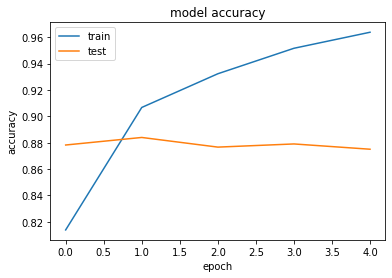

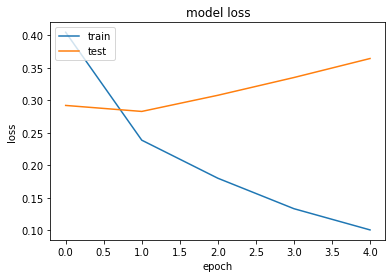

In [21]:
import matplotlib.pyplot as plt

# График точности модели
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# График оценки loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GRU, LSTM
x_train = pad_sequences(tokenizer.texts_to_sequences(textDF))
x_test =  pad_sequences(tokenizer.texts_to_sequences(textDF_test))

textDF.tolist()[:10]

["this was an absolutely terrible movie  don't be lured in by christopher walken or michael ironside  both are great actors  but this must simply be their worst role in history  even their great acting could not redeem this movie's ridiculous storyline  this movie is an early nineties us propaganda piece  the most pathetic scenes were those when the columbian rebels were making their cases for revolutions  maria conchita alonso appeared phony  and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning  i am disappointed that there are movies like this  ruining actor's like christopher walken's good name  i could barely sit through it ",
 'i have been known to fall asleep during films  but this is usually due to a combination of things including  really tired  being warm and comfortable on the sette and having just eaten a lot  however on this occasion i fell asleep because the film was rubbish  the plot development wa

In [0]:
gru = Sequential()
gru.add(Embedding(2**13, 3))  # 2**13 is tokenizer num words 
gru.add(GRU(3))
gru.add(ks.layers.Dense(2, activation='sigmoid'))


In [24]:
gru.compile(loss=ks.losses.BinaryCrossentropy(),
             optimizer=ks.optimizers.Adam(1e-3),
             metrics=['accuracy'])
gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 3)           24576     
_________________________________________________________________
gru_1 (GRU)                  (None, 3)                 63        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8         
Total params: 24,647
Trainable params: 24,647
Non-trainable params: 0
_________________________________________________________________


In [25]:

print(x_train)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

history = gru.fit(x_train, y_train, epochs=12, 
                  batch_size=100, validation_data=(x_test, y_test)) 


[[   0    0    0 ...  859  140    9]
 [   0    0    0 ...   19   30   29]
 [   0    0    0 ...  415    8 6001]
 ...
 [   0    0    0 ...   15   11   28]
 [   0    0    0 ...   77 1277   22]
 [   0    0    0 ...   31 1649  701]]
(25000, 2099)
(25000, 2169)
(25000, 2)
(25000, 2)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/12
25000/25000 [==============================] - 320s 13ms/step - loss: 0.6818 - accuracy: 0.5998 - val_loss: 0.6390 - val_accuracy: 0.6812
Epoch 2/12
25000/25000 [==============================] - 321s 13ms/step - loss: 0.4671 - accuracy: 0.7984 - val_loss: 0.4213 - val_accuracy: 0.8244
Epoch 3/12
25000/25000 [==============================] - 320s 13ms/step - loss: 0.3608 - accuracy: 0.8593 - val_loss: 0.3941 - val_accuracy: 0.8351
Epoch 4/12
25000/25000 [==============================] - 316s 13ms/step - loss: 0.3507 - accuracy: 0.8635 - val_loss: 0.3923 - val_accuracy: 0.8352
Epoch 5/12
25000/25000 [==============================] - 317s 13ms/step - loss: 0.3067 - accuracy: 0.8837 - val_loss: 0.4034 - val_accuracy: 0.8322
Epoch 6/12
25000/25000 [==============================] - 315s 13ms/step - loss: 0.2882 - accuracy: 0.8919 - val_loss: 0.3829 - val_accuracy: 0.8421
Epoch 7/12
25000/25000 [==============================] 